In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
torch.cuda.empty_cache()

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

dataset = ImageFolder("train/", transform= transform)
len(dataset)

88011

In [5]:
seed = 892
torch.manual_seed(seed)

In [6]:
batch_size = 1000
train_size = 75000

val_size = len(dataset) - train_size


val_dataset, train_dataset = data.random_split(dataset, lengths=[val_size, train_size])

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True, num_workers=1)
val_loader = data.DataLoader(val_dataset, batch_size=100, pin_memory=True, num_workers=1)
print(len(val_dataset), len(train_dataset))
int(len(train_dataset)/batch_size)

13011 75000


75

In [7]:
class ImageClassifierNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()

    def train_step(self, input, labels):
        input = input.to(device=device)#, non_blocking=True)
        labels = labels.to(device=device)#, non_blocking = True)

        preds = self.forward(input)
        loss = self.loss(preds, labels)

        return loss

    def val_step(self, input, labels):

        input = input.to(device=device)#, non_blocking=True)
        labels = labels.to(device=device)#, non_blocking = True)

        preds = self.forward(input)
        loss = self.loss(preds, labels)
        accuracy = self._accuracy(preds, labels)

        return {"loss":loss.detach(), "accuracy":accuracy}


    def val_epoch_end(self, preformance_measurement_data):

        accuracy = [x["accuracy"].cpu().numpy() for x in preformance_measurement_data]
        avg_accuracy = np.mean(accuracy)

        loss = [x["loss"].cpu().numpy() for x in preformance_measurement_data]
        avg_loss = np.mean(loss)

        return avg_loss, avg_accuracy


    def _accuracy(self, preds, labels):
        batch_size = len(preds)

        pred_indices = torch.argmax(preds, dim=1)
        return torch.tensor(torch.sum(pred_indices == labels).item() / batch_size)





In [8]:
class ResNetBlock(nn.Module):
    """ RestNet block with BN and full pre-activation """
    def __init__(self, in_channels, out_channels_conv1, out_channels_conv2, kernel_size=[3, 3], stride=[1,1], padding=[1,1]):
        super().__init__()

        self.network = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels_conv1, kernel_size=kernel_size[0], stride=stride[0], padding=padding[0]),
            nn.BatchNorm2d(out_channels_conv1), #<------------
            nn.ReLU(),
            nn.Conv2d(out_channels_conv1, out_channels_conv2, kernel_size=kernel_size[1], stride=stride[1], padding=padding[1])
        )


    def forward(self, input):
        return self.network(input) + input




class ResNetBlockChangeDepth(ResNetBlock):
    """ RestNet block with depth resize """
    def __init__(self, in_channels, out_channels_conv1, out_channels_conv2, res_conv_kernel_size=1, res_conv_stride=1, res_conv_padding=0, kernel_size=[3, 3], stride=[1,1], padding=[1,1]):

        super().__init__(in_channels, out_channels_conv1, out_channels_conv2, kernel_size, stride, padding)

        self.conv = nn.Conv2d(in_channels, out_channels_conv2, kernel_size=res_conv_kernel_size, stride=res_conv_stride, padding=res_conv_padding)

    def forward(self, input):
        return self.network(input) + self.conv(input)



class Wrapper(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


In [9]:
class ResNet(ImageClassifierNetwork):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.resnet_block1_1 = ResNetBlock(64, 64, 64)
        self.resnet_block1_2 = ResNetBlockChangeDepth(64, 128, 128)

        self.resnet_block2_1 = ResNetBlock(128, 128, 128)
        self.resnet_block2_2 = ResNetBlockChangeDepth(128, 256, 256)
        self.resnet_block2_3 = ResNetBlockChangeDepth(256, 256, 256) #<------------


        self.network = nn.Sequential(

            # Prep 3x64x64
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32x32

            nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64x16x16

            Wrapper(self.resnet_block1_1),
            Wrapper(self.resnet_block1_2),
            nn.MaxPool2d(2, 2), # 128x8x8

            Wrapper(self.resnet_block2_1),
            Wrapper(self.resnet_block2_2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # 256x4x4

            nn.Flatten(),
            # Fully connected layer
            nn.Linear(4*1024, num_classes),

        )


    def forward(self, input):
        return self.network(input)

In [10]:
class ResNet2(ImageClassifierNetwork):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.resnet_block1_1 = ResNetBlock(32, 32, 32)
        self.resnet_block1_3 = ResNetBlockChangeDepth(32, 64, 64)

        self.resnet_block2_1 = ResNetBlock(64, 64, 64)
        self.resnet_block2_3 = ResNetBlockChangeDepth(64, 128, 128)

        self.resnet_block3_1 = ResNetBlock(128, 128, 128)
        self.resnet_block3_2 = ResNetBlockChangeDepth(128, 256, 256)

        self.resnet_block4_1 = ResNetBlock(256, 256, 256)
        self.resnet_block4_2 = ResNetBlockChangeDepth(256, 512, 512)



        self.network = nn.Sequential(

            # Prep 3x64x64
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32x32

            Wrapper(self.resnet_block1_1),
            Wrapper(self.resnet_block1_3),
            nn.MaxPool2d(2, 2),  # 64x16x16

            Wrapper(self.resnet_block2_1),
            Wrapper(self.resnet_block2_3),
            nn.MaxPool2d(2, 2), # 128x8x8

            Wrapper(self.resnet_block3_1),
            Wrapper(self.resnet_block3_2),
            nn.MaxPool2d(2, 2), # 256x4x4

            Wrapper(self.resnet_block4_1),
            Wrapper(self.resnet_block4_2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # 512x2x2

            nn.Flatten(),
            # Fully connected layer
            nn.Linear(2048, num_classes),

        )


    def forward(self, input):
        return self.network(input)

In [11]:
model = ResNet(3, 50)
# model.load_state_dict(torch.load("30epoch_extended_with_agumentation_model1_70acc.pt"))

model.to(device)

ResNet(
  (loss): CrossEntropyLoss()
  (resnet_block1_1): ResNetBlock(
    (network): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (resnet_block1_2): ResNetBlockChangeDepth(
    (network): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )

In [12]:
# RestNet +- 7epoch;; RestNet_2 +- 10epoch "||" z agumentacją + 30epch RestNet2
epoch = 40

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 2e-2, epochs=epoch, steps_per_epoch=int(len(train_dataset)/batch_size))

In [13]:
params_sum = 0
for params in model.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

1778130

In [14]:
def eval(val_loader):
    history = []
    for input, label in val_loader:
        history += [model.val_step(input, label)]

    loss_val, acc_val = model.val_epoch_end(history)

    return loss_val, acc_val

In [15]:
transform = transforms.RandomChoice(
    [
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(20),
    transforms.RandomErasing(0.5),
    transforms.RandomInvert(0.5),
    # transforms.RandomPerspective(distortion_scale=.4)
    ]
)

In [16]:
def train(train_dataloader, epoch):
    model.train(mode=True)

    epoch_loss_T = []
    batch_loss_T = []
    epoch_loss_V = []
    epoch_acc_V = []


    for ep in range(epoch):

        # i=1
        for input, label in train_dataloader:
            # print(i)
            # i+=1

            input = transform(input)
            loss = model.train_step(input, label)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            lr_scheduler.step()

            batch_loss_T += [loss.item()]

        epoch_loss_T += [np.mean(batch_loss_T)]
        batch_loss_T = []

        loss_val, acc_val = eval(val_loader)
        epoch_loss_V += [loss_val]
        epoch_acc_V += [acc_val]

        print(f'Epoch {ep+1}; TLoss: {epoch_loss_T[ep]}; Vloss: {loss_val}; Acc: {acc_val}')


    model.eval()
    return epoch_loss_T, epoch_loss_V, epoch_acc_V

In [17]:
loss_T, loss_V, acc_V = train(train_loader, epoch)


Epoch 1; TLoss: 3.1522722657521567; Vloss: 2.6210741996765137; Acc: 0.2969743609428406


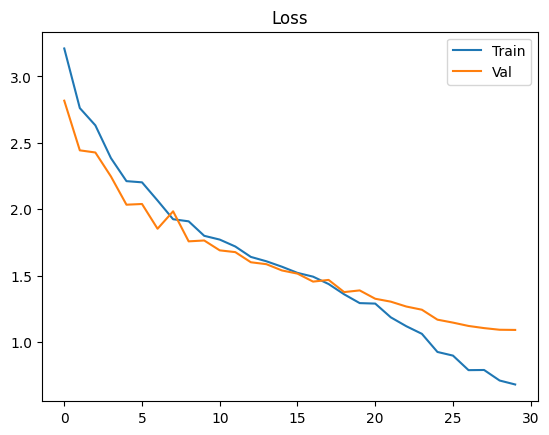

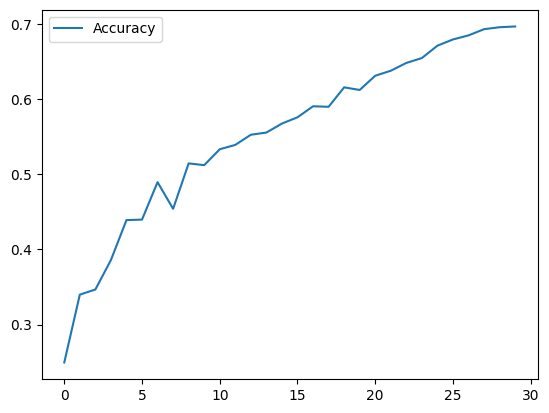

In [ ]:
def plot_results(loss_T, loss_V, acc_V):

    # fig = plt.figure
    plt.plot(loss_T, label="Train")
    plt.plot(loss_V, label="Val")
    plt.title("Loss")
    plt.legend()
    plt.show()

    # fig2 = plt.figure
    plt.plot(acc_V, label="Accuracy")
    plt.legend()
    plt.show()

plot_results(loss_T, loss_V, acc_V)

In [ ]:
torch.save(model.state_dict(), "40epoch_extended_with_agumentation_and_RES_NORM_model_acc.pt")
#

In [ ]:
# model = ResNet(3, 50)
# model.load_state_dict(torch.load("test_model.pt"))
